# Trend_Following_Backtesting
**Author**: Hansen Han  
**Date**: February 4th, 2023  
  
  
**Overview**: I originally wrote this when I was actively running automated cryptocurrency trading strategies in 2020. I wanted to briefly explore how well trend following could perform on cryptocurrency trading. Here, I took 1 minute bitcoin data from 2013 through 2019 and wrote a simple moving average (SMA) crossover system to see how well it would perform. Afterwards, I did a crude optimization to find the best parameters by re-running the algorithm with random parameters to see how well they affected the returns. 
  
  
**Results**: A SMA crossover strategy (2 day MA and 7 day MA) yielded higher cumulative returns (145,296%) than buying and holding bitcoin (6,069%) from 2013 to 2019. For the 2 day MA and 7 day MA strategy, the number of trades, profitability, and hit rate per quarter was highly variable with most gains occuring in a few quarters. From testing hundreds of different moving averages, it appeared that long averages between 200 and 400 hours, and a short moving average length between 0 and 200 hours yielded the highest cumulative returns.

**Limitations**: 

- There are gaps in the price data, since this was just exploratory I wrote the code to assume that every 60 entries was an hour even there are gaps (since it is over such a long timeframe, I don't imagine the end result would be dramatically different, but it is well worth looking into if you are seriously planning to run this kind of strategy)
- Does not factor in exchange fees (although the lower trading volume shouldn't affect the result against baseline too much here)
- When calculating quarterly returns, there is a gap after each quarter where the moving average is being calculated again and no trades are made ("warming up"). It would probably be better to calculate it across the whole dataset and cut by quarter instead of running the backtester in batches. (This is also why in the optimization step, the cumulative baseline returns are also variable, because it only considers buying and holding in times that the trend follower is active, and it also skips the gaps where it is "warming up"). This might also contribute to why we see that runs using longer moving averages have lower returns.
  
**Future Directions**: 
- Does performance improve if you add the ability to short-sell? 
- Adding data from 2019 to 2023 (present day)
- Running on different cryptocurrency coins (and altcoins)
- Trying different moving average approaches like exponential moving average (EMA) or weighted moving average (WMA)
- Adding better metrics to assess model performance (sharpe ratio, alpha, beta, etc...)
- Reduce overfitting (or understand how much overfitting is occuring) when searching for the best parameters by using cross validation
- Get quarterly performance by running the whole backtest in one go, then cutting the performance into quarters to address time gaps in the backtest data stemming from "warm ups" at the start of each quarter when moving averages haven't been calculated yet

#### Load Data

In [2]:
# Load 1 min BTC data from 2013 to 2019
import pandas as pd

df2019 = pd.read_csv("BTC_1min_bitfinex/2019.txt", header=None)
df2018 = pd.read_csv("BTC_1min_bitfinex/2018.txt", header=None)
df2017 = pd.read_csv("BTC_1min_bitfinex/2017.txt", header=None)
df2016 = pd.read_csv("BTC_1min_bitfinex/2016.txt", header=None)
df2015 = pd.read_csv("BTC_1min_bitfinex/2015.txt", header=None)
df2014 = pd.read_csv("BTC_1min_bitfinex/2014.txt", header=None)
df2013 = pd.read_csv("BTC_1min_bitfinex/2013.txt", header=None)

frames = [df2013, df2014, df2015, df2016, df2017, df2018, df2019]
crypto_df = pd.concat(frames)
crypto_df.rename(columns = {0: 'timestamp', 1: 'open', 2: 'close', 3: 'high', 4: 'low', 5: 'volume'}, inplace=True)

# Convert UTC timestamp to readable 
from datetime import datetime
crypto_df['timestamp'] = [datetime.utcfromtimestamp(int(ts)/1000).strftime('%Y-%m-%d %H:%M:%S') for ts in crypto_df['timestamp']]

#Convert into roughly hourly data (note: some data is missing!, not ideal)
crypto_df = crypto_df[::60]
crypto_df.head()


,timestamp,open,close,high,low,volume
0,2013-04-01 00:07:00,93.25000,93.30000,93.30000,93.25000,93.300000
60,2013-04-01 10:25:00,95.00000,95.00000,95.00000,95.00000,10.470000
120,2013-04-01 14:44:00,102.00000,102.40000,102.40000,102.00000,3.406266
180,2013-04-01 16:29:00,103.20000,103.20000,103.20001,103.20000,25.000000
240,2013-04-02 01:01:00,102.89999,102.89999,102.89999,102.89999,0.032839


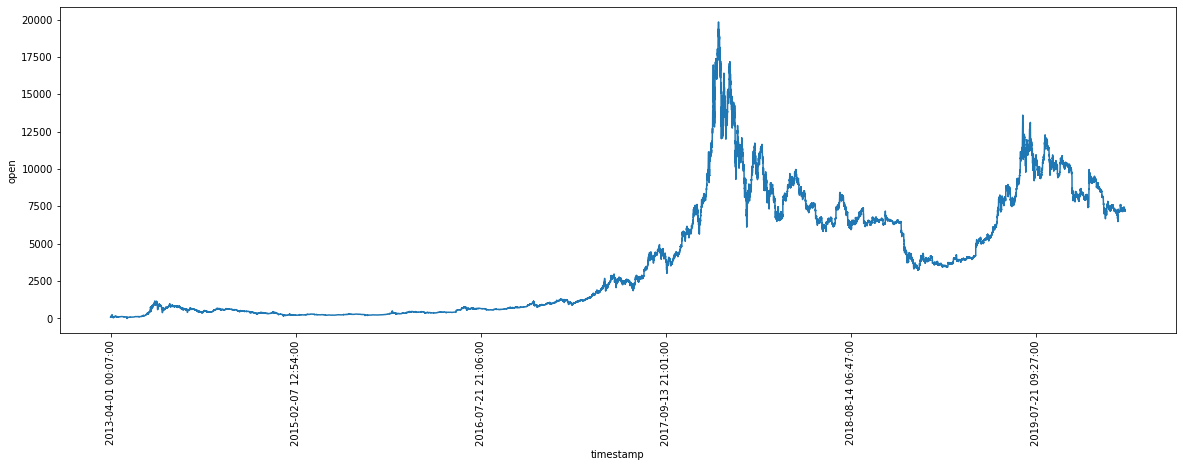

In [3]:
# View the data to make sure it looks right 
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import warnings
warnings.filterwarnings('ignore')
#plt.style.use('dark_background')

#sns.set_context("talk")
plt.figure(figsize=(20,6))
ax = sns.lineplot(x="timestamp", y="open", 
            data=crypto_df, ci=None)
ax.xaxis.set_major_locator(ticker.MaxNLocator(7))
plt.xticks(rotation="vertical")

plt.show() # looks right...

#### Simple Moving Average (SMA) Crossover Strategy Backtesting

In [26]:
import numpy as np

def sma_crossover_backtester(sampled_data, 
                            order_sizing, 
                            ma1_length, 
                            ma2_length, 
                            starting_capital,
                            display_results):
    """ 
    Parameters:
        sampled_data: pandas dataframe that must have columns 'timestamp' and 'price'
        order_sizing: how much of available capital to use on a given trade (betwen 0 and 1)
        ma1_length: moving average 1 length (in hours)
        ma2_length: moving average 2 length (in hours, must be longer than ma1_length)
        starting_capital: how much capital to start with (USD)
        display_results: plot the portfolio value over time (true or false)
    Returns:
        return_rate: ROI for the given time period
        total_trades: total number of trades made
        hit_rate: the proportion of trades that were profitable
        baseline_return_rate: ROI if you had bought and held
    """

    # Ensure inputs are valid
    if "timestamp" not in sampled_data.columns:
        return "Could not run ma_crossover_backtester(), 'timestamp' column missing from data."
    if "price" not in sampled_data.columns:
        return "Could not run ma_crossover_backtester(), 'price' column missing from data."
    if ma2_length < ma1_length:
        return "Could not run ma_crossover_backtester(), ma1_length is larger than ma2_length."
    if starting_capital <= 0:
        return "Could not run ma_crossover_backtester(), starting_capital must be greater than zero."
    if order_sizing > 1 or order_sizing <= 0:
        return "Could not run ma_crossover_backtester(), order_sizing must be between 1 and 0."
    
    
    fiat = starting_capital
    position_size = 0
    baseline_position_size = 0
    portfolio_balance = [] #keeps track of the total portfolio worth
    baseline_balance = [] #keeps track of the buy and hold balance
    moves = [] #keep track of buys and sells
    trades = 0
    purchase_price = 0
    wins = 0
    losses = 0

    ma1 = sampled_data.price.rolling(ma1_length).mean()
    ma2 = sampled_data.price.rolling(ma2_length).mean()

    #truncate the data so they all are aligned 
    ma1 = list(ma1[ma2_length:])
    ma2 = list(ma2[ma2_length:])
    sampled_data = sampled_data[ma2_length:]
    last_average_higher = "None"
    
    #now run through each moment in the data and check if there is a crossover
    for x in range(0, len(sampled_data['price'])):

        #get the current price
        current_price = list(sampled_data['price'])[x]

        if x == 0:
            baseline_initial = current_price
            baseline_position_size = starting_capital/current_price
        
        #keep track of which one was higher previously
        if ma1[x] > ma2[x]:
            current_average_higher = "MA1"
        elif ma1[x] < ma2[x]:
            current_average_higher = "MA2"
        else:
            current_average_higher = "None"

        if x == 0:
            moves.append("Pass")
        else:
            #begin the trading mechanism

            #if the shorter average crosses over the longer average - BUY
            if current_average_higher == "MA1" and last_average_higher == "MA2":
                #add the btc amount to the position
                position_size = position_size + (order_sizing*fiat)/current_price #add the btc purchased
                fiat = fiat - order_sizing*fiat #subtract the amount of capital used
                moves.append("Buy")
                trades = trades + 1
                purchase_price = current_price

            #if the shorter average goes under the longer average - SELL
            elif current_average_higher == "MA2" and last_average_higher == "MA1":
                fiat = fiat + position_size*current_price
                position_size = 0
                moves.append("Sell")
                trades = trades + 1

                # record whether the trade was profitable
                if purchase_price < current_price:
                    wins = wins + 1 
                else:
                    losses = losses + 1
                
                # reset the purchase price
                purchase_price = 0

            else:
                moves.append("Pass")
        
        #record the portfolio information
        portfolio_balance.append(position_size*current_price + fiat)
        baseline_balance.append(baseline_position_size*current_price)
        
        #record which moving average was higher this moment
        last_average_higher = current_average_higher
    
    # compute final results
    baseline_final = current_price
    baseline_return_rate = (baseline_final/baseline_initial) - 1    
    final_return_rate = (portfolio_balance[len(portfolio_balance) - 1]/starting_capital) - 1
    if (losses + wins) > 0:
        hit_rate = wins/(losses + wins)
    else:
        hit_rate = "N/A"

    # plot the final data
    if display_results == True:
        plot_data = pd.DataFrame()
        plot_data['time'] = sampled_data['timestamp']
        plot_data['Baseline'] = baseline_balance
        plot_data['SMA Crossover'] = portfolio_balance

        plt.figure(figsize=(20,6))
        plot_data.plot(x = "time")
        plt.xticks(rotation="vertical")
        plt.show()
    
    return final_return_rate, trades, hit_rate, baseline_return_rate



<Figure size 1440x432 with 0 Axes>

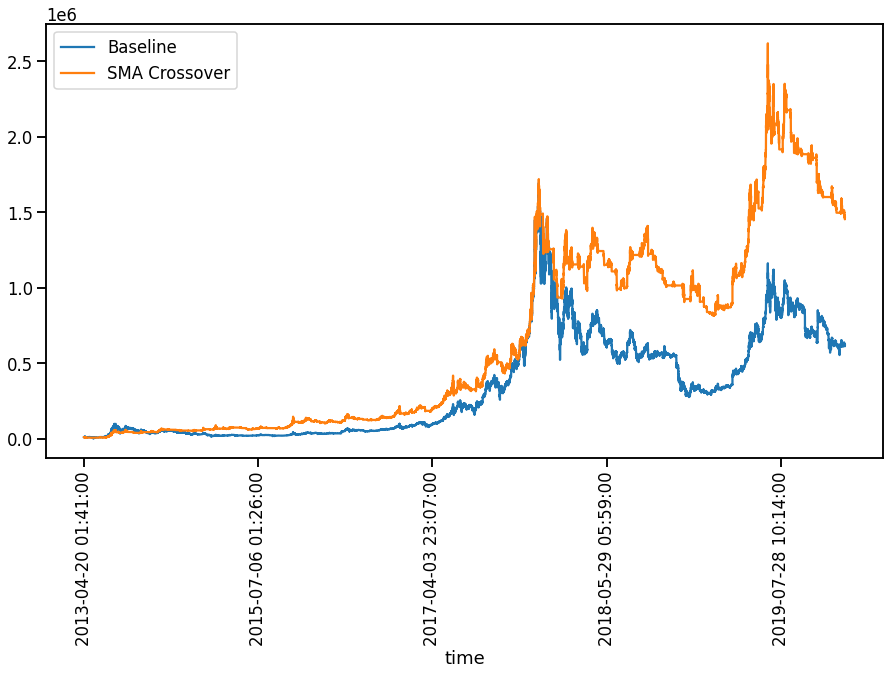

(145.29615323069038, 285, 0.4295774647887324, 60.639624252775405)

In [27]:
# Run the crossover backtester on the whole dataset 
crypto_df['price'] = crypto_df['open'] # set open to be the price to use 

sma_crossover_backtester(
            sampled_data = crypto_df,
            order_sizing = 1,
            ma1_length = 48, 
            ma2_length = 168, 
            starting_capital = 10000,
            display_results=True
        )

In [8]:
# We want to visualize how stable a strategy is over time...
# ...by visualizing the returns every quarter (3 months)

def quarterly_backtester(
        crypto_df,
        ma1_length,
        ma2_length,
        order_sizing,
        display_results
):
    '''
    Test the performance of sma crossover strategy over several quarters.
    
    Parameters:
        crypto_df: price data, should be in hourly intervals
        ma1_length: short moving average length (hours)
        ma2_length: long moving average length (hours)
        order_sizing: how much of available fiat to use per trade (between 0 and 1)
        display_results: plot charts to visualize results after running
    Returns:
        median_return_rate: median return rate across quarters
        stdev_return_rate: standard deviation in return rate across quarters
        profitable_quarters: how many quarters were profitable
        cumulative_return: total cumulative return from start to end using the strategy
        cumulative_baseline_return: total cumulative return from buying and holing
    '''

    import math
    import statistics

    three_month_hours = 2191

    # calculate the total number of quarters in the dataset
    total_quarters = math.floor(len(crypto_df.index)/three_month_hours)

    quarter_numbers = []
    quarter_return_rates = []
    quarter_trades = []
    quarter_hit_rates = []
    baseline_return_rates = []
    # cut the dataset into sections and run it through the tester
    for quarter_number in range(0, total_quarters):
        start_point = 0 + three_month_hours*quarter_number
        end_point = three_month_hours + three_month_hours*quarter_number

        sampled_data = crypto_df[start_point:end_point]
        
        #set the price to the open price to work with the sma_crossover_backtester()
        if "price" not in sampled_data.columns:
            sampled_data['price'] = sampled_data['open']
        
        final_return_rate, trades, hit_rate, baseline_return_rate = sma_crossover_backtester(
            sampled_data = sampled_data,
            order_sizing = order_sizing,
            ma1_length = ma1_length, 
            ma2_length = ma2_length, 
            starting_capital = 10000,
            display_results=False
        )

        quarter_numbers.append(quarter_number)
        quarter_return_rates.append(final_return_rate)
        quarter_trades.append(trades)
        quarter_hit_rates.append(hit_rate)
        baseline_return_rates.append(baseline_return_rate)


    quarterly_data = pd.DataFrame()
    quarterly_data['quarter'] = [x + 1 for x in quarter_numbers]
    quarterly_data['return'] = [x*100 for x in quarter_return_rates]
    quarterly_data['trades'] = quarter_trades
    quarterly_data['hit_rate'] = quarter_hit_rates
    quarterly_data['baseline'] = baseline_return_rates

    # compute some metrics about overall performance
    median_return_rate = statistics.median(quarter_return_rates)
    stdev_return_rate = statistics.stdev(quarter_return_rates)
    profitable_quarters = len([x for x in quarter_return_rates if x > 0])

    # calculate the cumulative return for the performance over all quarters
    cumulative_return = 1
    for return_rate in quarter_return_rates:
        cumulative_return = cumulative_return * (1 + return_rate)

    cumulative_baseline_return = 1
    for baseline_return_rate in baseline_return_rates:
        cumulative_baseline_return = cumulative_baseline_return * (1+baseline_return_rate)

    if display_results == True:
        from matplotlib import rcParams

        rcParams['figure.figsize'] = 15,8


        # Plot Results
        # Hit Rate
        clrs = ['green' if (x > 0) else 'red' for x in quarter_return_rates]
        graph = sns.barplot(x="quarter",y="hit_rate",data=quarterly_data,palette=clrs)
        #Drawing a horizontal line at 0.5
        graph.axhline(0.5)
        plt.show()

        # Returns
        clrs = ['green' if (x > 0) else 'red' for x in quarter_return_rates]
        graph = sns.barplot(x="quarter",y="return",data=quarterly_data,palette=clrs)
        plt.show()

        # Number of Trades
        graph = sns.barplot(x="quarter",y="trades",data=quarterly_data,palette=clrs)
        plt.show()

        # Comparison plot
        comparison_df = pd.DataFrame()
        comparison_df['Return']  = quarter_return_rates + baseline_return_rates
        comparison_df['Quarter'] = [x + 1 for x in quarter_numbers] + [x + 1 for x in quarter_numbers]
        comparison_df['Strategy'] = ["SMA Crossover" for x in quarter_numbers] + ["Buy and Hold" for x in quarter_numbers]

        sns.barplot(data=comparison_df, x='Quarter', y='Return', hue='Strategy')
        plt.show()


        
    
    return median_return_rate, stdev_return_rate, profitable_quarters, cumulative_return, cumulative_baseline_return



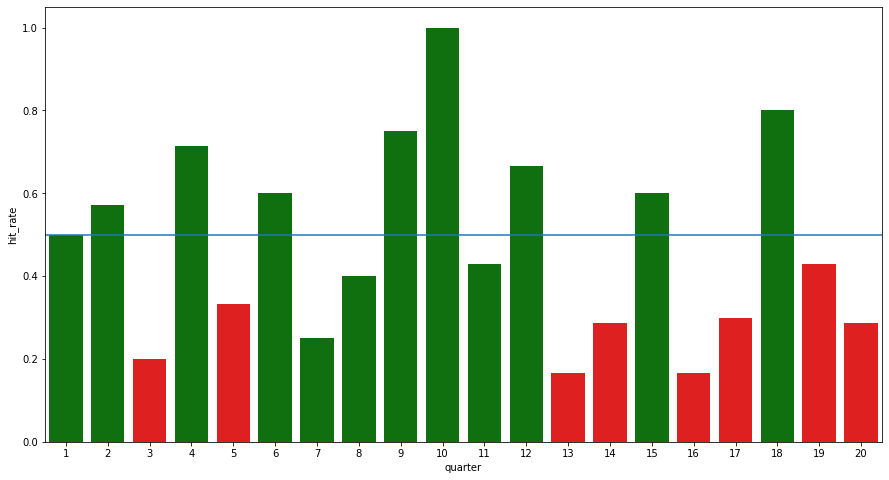

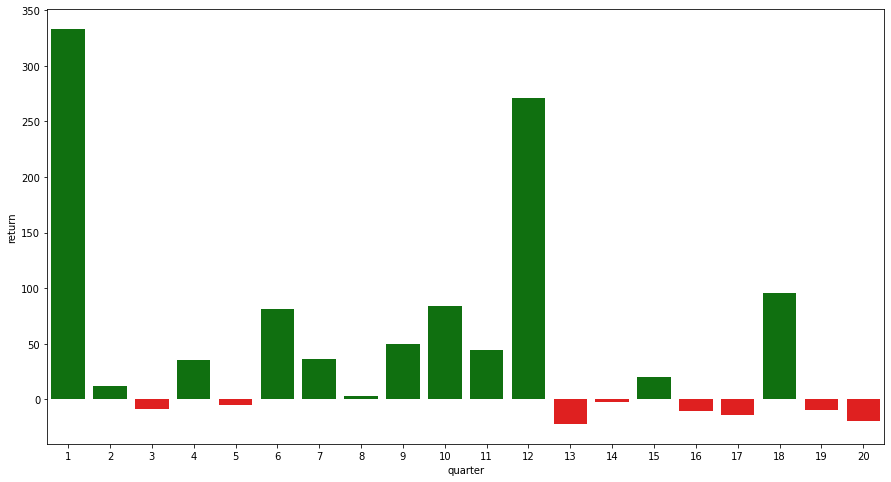

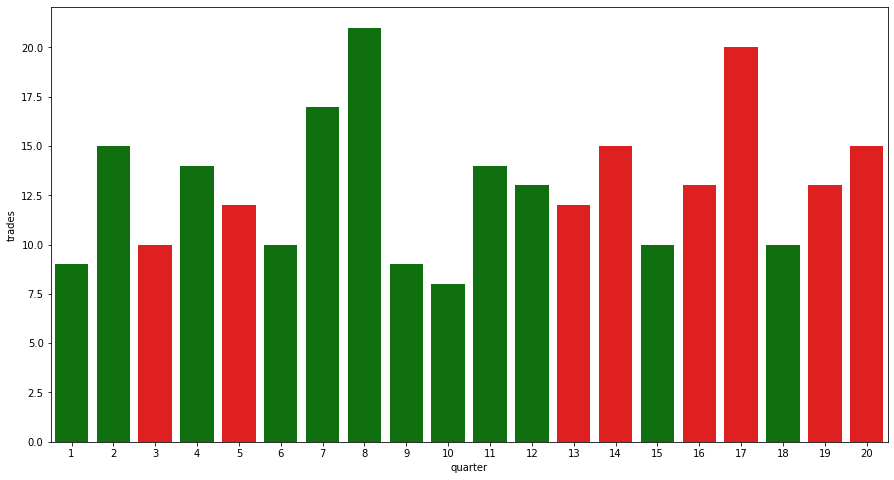

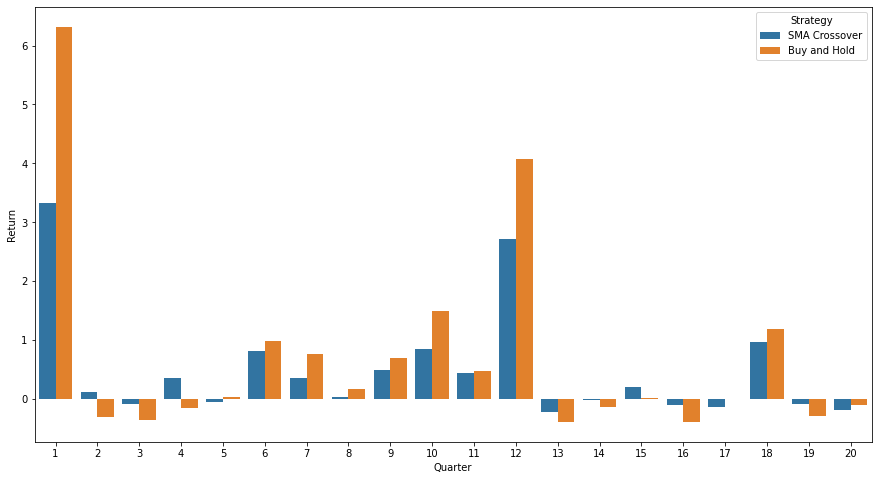

(0.1592889769102115,
 0.9430500783108069,
 12,
 210.50934629066705,
 160.03934382868127)

In [6]:
# Test the quarterly backtester out... 
quarterly_backtester(
    crypto_df = crypto_df,
    ma1_length = 48, # 2 days
    ma2_length = 168, #7 days
    order_sizing = 1,
    display_results = True
)

# When we convert cumulative returns from decimal to percent (210.509 * 100), we get 21,509%! (over 7 years!) 

### What are the optimal parameters for SMA crossover strategy? 

In [28]:
def random_ma_length_generator():
    """
    Generate random moving averages for optimization purposes.
    """
    import random
    num1 = random.randrange(0, round(2191/2))
    num2 = random.randrange(0, round(2191/2))
    while num2 < num1:
        num2 = random.randrange(0, round(2191/2))
    
    return num1, num2

# test lots of combinations
ma_combinations = []
median_return_rate_results = []
stdev_return_rate_results = []
profitable_quarters_results = [] 
cumulative_return_results = []
cumulative_baseline_return_results = []

# run 150 different combinations
for x in range(0, 150):
    ma1_length, ma2_length = random_ma_length_generator()
    ma_combinations.append((ma1_length, ma2_length))

    median_return_rate, stdev_return_rate, profitable_quarters, cumulative_return, cumulative_baseline_return = quarterly_backtester(
        crypto_df = crypto_df,
        ma1_length = ma1_length,
        ma2_length = ma2_length, 
        order_sizing = 1,
        display_results = False
    )

    median_return_rate_results.append(median_return_rate)
    stdev_return_rate_results.append(stdev_return_rate)
    profitable_quarters_results.append(profitable_quarters)
    cumulative_return_results.append(cumulative_return)
    cumulative_baseline_return_results.append(cumulative_baseline_return)

# compile results into a table for exploration
optimization_results = pd.DataFrame()
optimization_results["ma1_length"] = [x[0] for x in ma_combinations]
optimization_results["ma2_length"] = [x[1] for x in ma_combinations]
optimization_results["median_return_rate"] = median_return_rate_results
optimization_results["stdev_return_rate"] = stdev_return_rate_results
optimization_results["cumulative_return"] = cumulative_return_results
optimization_results["cumulative_baseline_return"] = cumulative_baseline_return_results
optimization_results["profitable_quarters"] = profitable_quarters_results
optimization_results.head()

# cumulative baseline return is variable here because of gaps per quarter (startup time where there moving average is being formed)...
# 

,ma1_length,ma2_length,median_return_rate,stdev_return_rate,cumulative_return,cumulative_baseline_return,profitable_quarters
0,949,1070,0.000000,0.637287,8.982014,50.702067,8
1,489,499,0.118147,1.700840,105.664136,83.141195,13
2,19,888,0.000000,1.489502,18.703084,140.729309,7
3,8,904,0.039420,1.517257,86.858961,164.549669,10
4,838,842,0.075630,0.866554,25.523172,75.476184,13


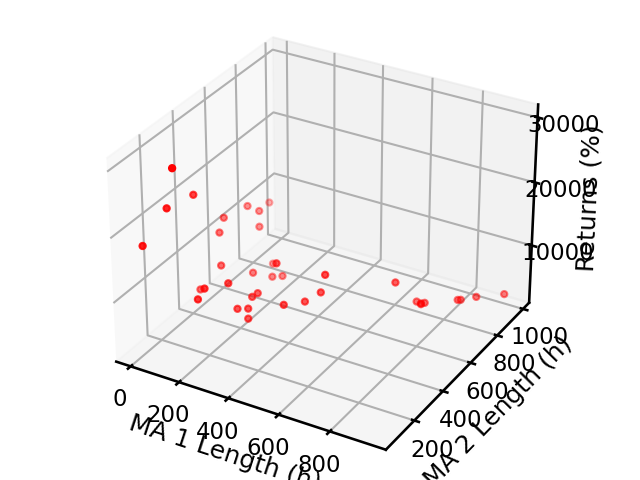

In [29]:
# For 2D plots
#sns.scatterplot(data=optimization_results, x="cumulative_return", y="stdev_return_rate")
#sns.scatterplot(data=optimization_results, x="cumulative_return", y="ma1_length")
#sns.scatterplot(data=optimization_results, x="cumulative_return", y="ma2_length")

# Create a 3D interactive plot to find relationships between moving average lengths and cumulative return rates
%matplotlib widget
  
# importing required libraries
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
#plt.style.use('classic')

# Plot the data for the top 25% of cumulative returns
xs = optimization_results[optimization_results.cumulative_return >= optimization_results.describe()['cumulative_return']['75%']]['ma1_length']
ys = optimization_results[optimization_results.cumulative_return >= optimization_results.describe()['cumulative_return']['75%']]['ma2_length']

# convert to %
zs = [x*100 for x in optimization_results[optimization_results.cumulative_return >= optimization_results.describe()['cumulative_return']['75%']]['cumulative_return']]

# Also try using this instead of cumulative return to look at median return 
#zs = [x*100 for x in optimization_results[optimization_results.cumulative_return >= optimization_results.describe()['cumulative_return']['75%']]['median_return_rate']]
  
# creating figure
fig = plt.figure()
ax = Axes3D(fig)
  
# creating the plot
optimization_plot = ax.scatter(xs, ys, zs, color='red')
  
# setting title and labels
ax.set_title("Moving Average Length and Cumulative Returns")
ax.set_xlabel('MA 1 Length (h)')
ax.set_ylabel('MA 2 Length (h)')
ax.set_zlabel('Returns (%)')
  
# displaying the plot
plt.show()

- From briefly looking at the 3D plot, it looks like a long moving average between 200 and 400 hours, and a short moving average length between 0 and 200 hours yields the highest returns.